# Clifford+T Gate Synthesis

Fault-tolerant quantum computation requires expressing circuits in terms of a **discrete universal gate set**. The standard choice is the **Clifford+T** gate set: $\{H, S, T, \text{CNOT}\}$.

While Clifford gates ($H$, $S$, CNOT) can be implemented transversally in surface codes with zero overhead, each **T gate** requires costly magic state distillation. The number of T gates is therefore the dominant resource cost for fault-tolerant quantum computing.

## Key concepts

- **Gridsynth**: An optimal algorithm that approximates any $R_Z(\theta)$ rotation using a sequence of $H$, $S$, and $T$ gates. The T-gate count scales as $\sim 3\log_2(1/\varepsilon)$ where $\varepsilon$ is the approximation precision.

- **Trasyn**: An alternative algorithm that directly approximates arbitrary SU(2) gates, sometimes using fewer T gates than decomposing into three $R_Z$ rotations.

- **KAK decomposition**: Any two-qubit gate (SU(4)) decomposes into 15 single-qubit $R_Z$ rotations interleaved with CNOTs. Each $R_Z$ is then individually synthesized to Clifford+T.

- **Redundancy removal**: Consecutive single-qubit rotations on the same qubit can be merged before synthesis, reducing the total $R_Z$ count and hence T gates.

In this notebook you will:
1. Synthesize individual $R_Z$ rotations using gridsynth
2. Study how T-gate count scales with precision
3. Compare gridsynth and trasyn for SU(2) synthesis
4. Synthesize two-qubit gates via KAK decomposition
5. Run the full pipeline: MPS $\to$ circuit $\to$ Clifford+T
6. Study how synthesis precision affects resource costs

## Setup

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using TenSynth
using TenSynth.Core
using TenSynth.MPS

using PyCall  # triggers TenSynthPyCallExt for gridsynth/trasyn

using LinearAlgebra
using Random
using Plots
gr()

Random.seed!(42)
println("TenSynth loaded with PyCall extension.")

  Activating project at `~/Documents/Programming/PhD/ClaudeCodeExperiments/TenSynth_Master/TenSynthRepo/TenSynth`
[ Info: Precompiling TenSynthPyCallExt [621b86de-7cee-5a9a-94c1-201a12e8b54d] 


TenSynth loaded with PyCall extension.


## 1. Synthesizing a Single Rotation

The gridsynth algorithm finds a short sequence of Clifford+T gates that approximates an arbitrary $R_Z(\theta)$ rotation to precision $\varepsilon$. The output is a **gate string** where each character represents one gate: `H` (Hadamard), `S` (phase), `T` ($\pi/8$), `X` (Pauli-X), or `I` (identity).

In [2]:
# Synthesize a specific RZ rotation
theta = 1.23    # arbitrary angle
epsilon = 1e-3  # target precision

seq, n_t, err = synthesize_rz(theta, epsilon)

println("Target rotation: RZ($theta)")
println("Precision:       \u03b5 = $epsilon")
println("Gate sequence:   $seq")
println("Sequence length: $(length(seq))")
println("T-gate count:    $n_t")
println("Approx. error:   $(round(err, sigdigits=3))")

# Verify: reconstruct the unitary from the gate string
U_approx = GSChars2U(seq)
U_target = RZ(theta)
verified_err = 1.0 - abs(tr(U_target' * U_approx)) / 2
println("\nVerified error:  $(round(verified_err, sigdigits=3))")

Target rotation: RZ(1.23)
Precision:       ε = 0.001
Gate sequence:   HTHTHTHTHTSHTHTSHTSHTHTSHTSHTHTSHTHTSHTSHTSHTSHTHTHTSHTHTHTHTSHTSHTSHTHTHTSHTHTHTSHTSSSWWWW
Sequence length: 91
T-gate count:    34
Approx. error:   4.9e-7

Verified error:  4.9e-7


## 2. T-Gate Scaling with Precision

A key result is that the T-gate count for approximating $R_Z(\theta)$ scales as $\sim 3\log_2(1/\varepsilon)$. This sub-linear growth is what makes fault-tolerant quantum computing practical: achieving $10\times$ better precision costs only about 10 additional T gates.

In [3]:
epsilons = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
theta_test = 0.7  # fixed angle

t_counts_eps = Int[]
errors_eps = Float64[]

for eps in epsilons
    seq, n_t, err = synthesize_rz(theta_test, eps)
    push!(t_counts_eps, n_t)
    push!(errors_eps, err)
    println("\u03b5 = $(rpad(eps, 8)):  T-gates = $(lpad(n_t, 3)),  error = $(round(err, sigdigits=2))")
end

# Theoretical prediction
t_predicted = [ceil(Int, 3 * log2(1/eps)) for eps in epsilons]
println("\nTheoretical (3 log\u2082(1/\u03b5)):  $t_predicted")

ε = 0.1     :  T-gates =   8,  error = 0.0048
ε = 0.01    :  T-gates =  18,  error = 4.7e-5
ε = 0.001   :  T-gates =  28,  error = 4.3e-7
ε = 0.0001  :  T-gates =  42,  error = 3.3e-9
ε = 1.0e-5  :  T-gates =  50,  error = 3.2e-11

Theoretical (3 log₂(1/ε)):  [10, 20, 30, 40, 50]


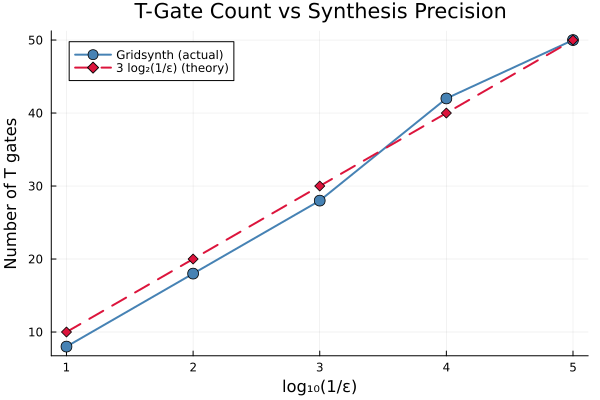

In [4]:
log_eps = [-log10(eps) for eps in epsilons]

p = plot(title="T-Gate Count vs Synthesis Precision",
         xlabel="log\u2081\u2080(1/\u03b5)", ylabel="Number of T gates",
         legend=:topleft, size=(600, 400))

plot!(p, log_eps, t_counts_eps,
      marker=:circle, linewidth=2, markersize=6,
      color=:steelblue, label="Gridsynth (actual)")

plot!(p, log_eps, t_predicted,
      marker=:diamond, linewidth=2, markersize=5,
      linestyle=:dash, color=:crimson, label="3 log\u2082(1/\u03b5) (theory)")

p

The actual T-gate count closely follows the theoretical $3\log_2(1/\varepsilon)$ scaling. Gridsynth achieves near-optimal gate counts -- each additional decade of precision costs roughly 10 T-gates.

## 3. SU(2) Synthesis: Trasyn vs Gridsynth

An arbitrary single-qubit gate (SU(2)) can be synthesized in two ways:
1. **3$\times$Gridsynth**: Decompose into three $R_Z$ angles via the XZX decomposition, then synthesize each independently
2. **Trasyn**: Directly search for a Clifford+T sequence approximating the full SU(2) gate

Trasyn can sometimes find shorter sequences because it jointly optimizes the approximation.

In [5]:
# Create a random SU(2) gate
Random.seed!(42)
thetas_su2 = randn(3) * 0.5
U_su2 = Thetas2SU2(thetas_su2)
epsilon_su2 = 1e-3

println("Random SU(2) from angles $(round.(thetas_su2, digits=3))")

# Method 1: Direct SU(2) via trasyn
seq_t, n_t_trasyn, err_t = synthesize_su2(U_su2, epsilon_su2; max_depth=30, num_attempts=3)

# Method 2: Decompose to 3 RZ angles, gridsynth each
thetas_rz = SU22Thetas(U_su2)
total_t_rz = 0
total_err_rz = 0.0
for theta in thetas_rz
    _, n_t, err = synthesize_rz(theta, epsilon_su2)
    total_t_rz += n_t
    total_err_rz += err
end

println("\nTrasyn (direct SU(2)):  T-gates = $n_t_trasyn,  error = $(round(err_t, sigdigits=3))")
println("3\u00d7Gridsynth (via RZ):  T-gates = $total_t_rz,  error = $(round(total_err_rz, sigdigits=3))")

diff_su2 = total_t_rz - n_t_trasyn
if diff_su2 > 0
    println("\nTrasyn saves $diff_su2 T-gates ($(round(100*diff_su2/total_t_rz, digits=1))% reduction)")
elseif diff_su2 < 0
    println("\nGridsynth uses $(-diff_su2) fewer T-gates in this case")
else
    println("\nBoth methods use the same number of T-gates")
end

Random SU(2) from angles [0.394, -0.44, -0.437]

Trasyn (direct SU(2)):  T-gates = 26,  error = 0.00302


/Users/joe/.pyjulia/lib/python3.13/site-packages/trasyn/synthesis.py:143: UserWarning: cupy not installed, falling back to numpy.
  warnings.warn("cupy not installed, falling back to numpy.")
/Users/joe/.pyjulia/lib/python3.13/site-packages/trasyn/synthesis.py:218: UserWarning: Error threshold 0.001 is not reached by the lowest error found: 0.0030165131865262655.
  warnings.warn(


3×Gridsynth (via RZ):  T-gates = 92,  error = 1.03e-6

Trasyn saves 66 T-gates (71.7% reduction)


## 4. Two-Qubit Gate Synthesis

Any two-qubit gate (element of SU(4)) can be decomposed via the **KAK decomposition** into four single-qubit blocks and three interaction angles:

$$U = (A_1 \otimes B_1) \cdot e^{i(\alpha_{xx} X\!\otimes\! X + \alpha_{yy} Y\!\otimes\! Y + \alpha_{zz} Z\!\otimes\! Z)} \cdot (A_2 \otimes B_2)$$

This yields **15 $R_Z$ rotations** (3 per single-qubit block $\times$ 4 blocks $+$ 3 interaction). Each $R_Z$ is synthesized to Clifford+T.

Alternatively, **grouped synthesis** treats each SU(2) block as a unit and uses trasyn for fewer T-gates.

In [6]:
# Create a random SU(4) gate
Random.seed!(123)
thetas_su4 = 0.3 * randn(15)
U_su4 = Thetas2SU4(thetas_su4)

epsilon_su4 = 1e-2

# Method 1: Per-RZ gridsynth (15 individual RZ)
seqs_gs, n_t_gs, err_gs = synthesize_su4(U_su4, epsilon_su4; use_trasyn=false)

# Method 2: Grouped trasyn (4 SU(2) blocks + 3 interaction RZ)
seqs_tr, n_t_tr, err_tr = synthesize_su4(U_su4, epsilon_su4; use_trasyn=true)

println("Per-RZ gridsynth (15 individual RZ):")
println("  T-gates:   $n_t_gs")
println("  Error:     $(round(err_gs, sigdigits=3))")

println("\nGrouped trasyn (4 SU(2) + 3 RZ):")
println("  T-gates:   $n_t_tr")
println("  Error:     $(round(err_tr, sigdigits=3))")

diff_su4 = n_t_gs - n_t_tr
if diff_su4 > 0
    println("\nGrouped trasyn saves $diff_su4 T-gates ($(round(100*diff_su4/n_t_gs, digits=1))% reduction)")
elseif diff_su4 < 0
    println("\nPer-RZ gridsynth uses $(-diff_su4) fewer T-gates")
else
    println("\nBoth methods use the same number of T-gates")
end

# Verify gridsynth approximation quality
U_gs_approx = RZs2SU4([GSChars2U(s) for s in seqs_gs])
fid_gs = abs(tr(U_su4' * U_gs_approx))^2 / 16
println("\nGridsynth gate fidelity: $(round(fid_gs, digits=6))")

Per-RZ gridsynth (15 individual RZ):
  T-gates:   206
  Error:     0.000316

Grouped trasyn (4 SU(2) + 3 RZ):
  T-gates:   117
  Error:     0.0536

Grouped trasyn saves 89 T-gates (43.2% reduction)

Gridsynth gate fidelity: 0.999481


## 5. Full Pipeline: MPS $\to$ Circuit $\to$ Clifford+T

Now let's put everything together. Given an MPS quantum state, TenSynth:
1. **Decomposes** the MPS into a circuit of SU(4) gates
2. **Removes redundancy** by merging consecutive single-qubit rotations
3. **Synthesizes** each remaining $R_Z$ to Clifford+T

Let's walk through each step on a random MPS.

In [7]:
# Create a random MPS (4 qubits, bond dim 2)
Random.seed!(42)
mps = randMPS(4, 2)

# Step 1: Decompose MPS into circuit
decomp = decompose(mps; method=:analytical, verbose=false)

println("Step 1 - MPS decomposition:")
println("  Qubits:          $(decomp.n_qubits)")
println("  Depth:           $(decomp.depth) layers")
println("  2-qubit gates:   $(decomp.n_gates)")
println("  Fidelity:        $(round(decomp.fidelity, digits=6))")
println("  Total RZ angles: $(15 * decomp.n_gates)")

Step 1 - MPS decomposition:
  Qubits:          4
  Depth:           10 layers
  2-qubit gates:   15
  Fidelity:        1.0
  Total RZ angles: 225


In [8]:
# Step 2: Redundancy removal (merging consecutive single-qubit gates)
_, rd_stats = remove_redundant_rotations(decomp.circuit, decomp.circuit_inds; verbose=false)

println("Step 2 - Redundancy removal:")
println("  Original non-trivial rotations: $(rd_stats[:original_rotations])")
println("  After merging:                  $(rd_stats[:final_rotations])")
println("  Merged pairs:                   $(rd_stats[:merged_pairs])")
println("  Estimated RZ savings:            $(rd_stats[:saved])")

# Step 3: Clifford+T synthesis
synth = synthesize(decomp.circuit, decomp.circuit_inds; epsilon=1e-3, verbose=false)

println("\nStep 3 - Clifford+T synthesis:")
println(summarize_synthesis(synth))

Step 2 - Redundancy removal:
  Original non-trivial rotations: 225
  After merging:                  147
  Merged pairs:                   26
  Estimated RZ savings:            78

Step 3 - Clifford+T synthesis:
=== Clifford+T Synthesis Summary ===
Method: gridsynth
RZ rotations: 225
T-gates: 6528
Clifford gates: 11378
Total gates: 17906
Approximation error: 6.79e-5
Average T/RZ: 29.0


## 6. The compile() One-Liner

The `compile()` function wraps the entire pipeline -- decomposition, redundancy removal, and synthesis -- into a single call. It returns a `CompilationResult` with complete statistics.

In [9]:
Random.seed!(99)
mps_6q = randMPS(6, 2)

result = compile(mps_6q;
    method=:analytical,
    synthesize_gates=true,
    epsilon=1e-3
)

result

CompilationResult:
  Qubits:            6
  Fidelity:          0.99986022
  Circuit depth:     20 layers
  2-qubit gates:     50
  Method:            :analytical
  T-gates:           21616
  Clifford gates:    37614
  Synthesis error:   0.00021758
  Synthesis epsilon: 0.001
  Elapsed time:      106.184 seconds


## 7. Resource Scaling with Precision

The synthesis precision $\varepsilon$ controls the tradeoff between T-gate count and approximation error. Let's sweep $\varepsilon$ and compare the actual T-gate count against the asymptotic estimate $N_T \approx 3 N_{\text{RZ}} \log_2(1/\varepsilon)$.

In [10]:
# Use the same 4-qubit decomposition, vary synthesis precision
Random.seed!(42)
mps_sweep = randMPS(4, 2)
decomp_sweep = decompose(mps_sweep; method=:analytical, verbose=false)

epsilons_sweep = [1e-1, 1e-2, 1e-3, 1e-4]

t_gates_sweep = Int[]
errors_sweep = Float64[]
est_sweep = Int[]

for eps in epsilons_sweep
    s = synthesize(decomp_sweep.circuit, decomp_sweep.circuit_inds;
                   epsilon=eps, verbose=false)
    push!(t_gates_sweep, s.n_t_gates)
    push!(errors_sweep, s.approximation_error)

    est = estimate_t_gates(decomp_sweep.circuit, eps)
    push!(est_sweep, est)

    println("\u03b5 = $(rpad(eps, 8)):  T-gates = $(lpad(s.n_t_gates, 4)),  ",
            "estimated = $(lpad(est, 4)),  error = $(round(s.approximation_error, sigdigits=2))")
end

ε = 0.1     :  T-gates = 1370,  estimated = 2250,  error = 0.48
ε = 0.01    :  T-gates = 4144,  estimated = 4500,  error = 0.0058
ε = 0.001   :  T-gates = 6508,  estimated = 6750,  error = 6.5e-5
ε = 0.0001  :  T-gates = 8894,  estimated = 9000,  error = 6.5e-7


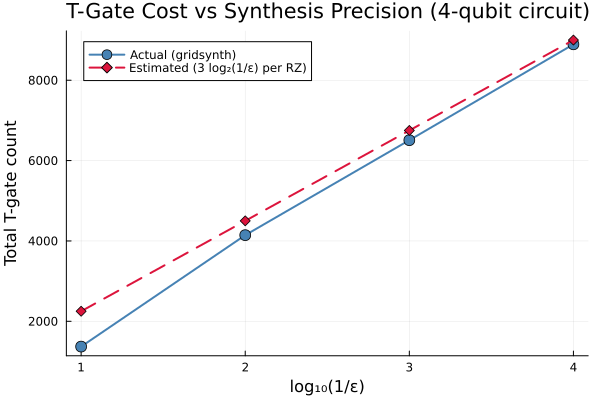

In [11]:
log_eps_sweep = [-log10(eps) for eps in epsilons_sweep]

p = plot(title="T-Gate Cost vs Synthesis Precision (4-qubit circuit)",
         xlabel="log\u2081\u2080(1/\u03b5)", ylabel="Total T-gate count",
         legend=:topleft, size=(600, 400))

plot!(p, log_eps_sweep, t_gates_sweep,
      marker=:circle, linewidth=2, markersize=6,
      color=:steelblue, label="Actual (gridsynth)")

plot!(p, log_eps_sweep, est_sweep,
      marker=:diamond, linewidth=2, markersize=5,
      linestyle=:dash, color=:crimson, label="Estimated (3 log\u2082(1/\u03b5) per RZ)")

p

The actual T-gate count is typically **lower** than the naive estimate because:
1. **Redundancy removal** merges consecutive single-qubit gates, reducing the number of $R_Z$ rotations
2. Some $R_Z$ angles are near-identity and require zero T-gates
3. Gridsynth can sometimes beat the asymptotic bound for specific angles

## Summary

In this notebook you learned:

- **Gridsynth** synthesizes individual $R_Z(\theta)$ rotations to Clifford+T sequences with T-gate count $\sim 3\log_2(1/\varepsilon)$
- **Trasyn** directly approximates SU(2) gates and can save T-gates by jointly optimizing instead of decomposing to three separate $R_Z$ rotations
- **Two-qubit gates** (SU(4)) decompose via KAK into 15 $R_Z$ rotations -- grouped trasyn can reduce this overhead
- **Redundancy removal** merges consecutive single-qubit rotations to reduce the total $R_Z$ count before synthesis
- The `compile()` function provides a one-line pipeline: MPS $\to$ circuit $\to$ Clifford+T
- T-gate counts scale sub-linearly with precision, making fault-tolerant quantum computing practical

**Key functions used:**
- `synthesize_rz(\u03b8, \u03b5)` -- synthesize single $R_Z$ rotation via gridsynth
- `synthesize_su2(U, \u03b5)` -- synthesize SU(2) gate via trasyn
- `synthesize_su4(U, \u03b5; use_trasyn)` -- synthesize SU(4) gate via KAK + gridsynth/trasyn
- `synthesize(circuit, inds; epsilon)` -- synthesize full circuit with redundancy removal
- `compile(mps; synthesize_gates=true, epsilon)` -- end-to-end MPS $\to$ Clifford+T pipeline
- `estimate_t_gates(circuit, \u03b5)` -- fast T-gate count estimate without actual synthesis
- `summarize_synthesis(result)` -- print synthesis summary